# Basic Manual RNN

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Constant

In [0]:
# Number of inputs for each example
num_inputs = 2

# Number of neurons in first layer
num_neurons = 3

### Placeholders

In [0]:
# We now need two Xs! One for each timestamp (t=0 and t=1)
x0 = tf.placeholder(tf.float32,[None,num_inputs])
x1 = tf.placeholder(tf.float32,[None,num_inputs])

### Variables

In [0]:
# We'll also need a Weights variable for each x
# Notice the shape dimensions on both!
Wx = tf.Variable(tf.random_normal(shape=[num_inputs,num_neurons]))

In [0]:
Wy = tf.Variable(tf.random_normal(shape=[num_neurons,num_neurons]))

In [0]:
b = tf.Variable(tf.zeros([1, num_neurons]))

### Graph

In [0]:
# First Activation
y0 = tf.tanh(tf.matmul(x0,Wx) + b)

In [0]:
y1 = tf.tanh(tf.matmul(y0,Wy) + tf.matmul(x1,Wx) + b)

#### Intialize Variabels

In [0]:
init = tf.global_variables_initializer()

### Create Data

In [0]:
# BATCH 0:       example1 , example2, example 3
x0_batch = np.array([ [0,1],[2,3],[4,5] ]) # DATA AT TIMESTAMP = 0

# BATCH 0:       example1 , example2, example 3
x1_batch = np.array([ [100,101],[102,103],[104,105] ]) # DATA AT TIMESTAMP = 0

### Run Session

In [0]:
with tf.Session() as sess:
  sess.run(init)
  
  y0_output_vals, y1_output_vals = sess.run([y0,y1],feed_dict={x0:x0_batch,x1:x1_batch})

In [12]:
# The output of values at t=0
y0_output_vals

array([[-0.9013045 ,  0.8681815 , -0.88914275],
       [-0.9777838 ,  0.9997542 , -0.9997669 ],
       [-0.9951503 ,  0.9999996 , -0.9999995 ]], dtype=float32)

In [13]:
# The output of values at t=1
y1_output_vals

array([[-1.,  1., -1.],
       [-1.,  1., -1.],
       [-1.,  1., -1.]], dtype=float32)

# RNN with TensorFlow API

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### The Data

In [0]:
class TimeSeriesData():
  def __init__(self,num_points,xmin,xmax):
    self.xmin = xmin
    self.xmax = xmax
    self.num_points = num_points
    self.resolution = (xmax-xmin)/num_points
    self.x_data = np.linspace(xmin,xmax,num_points)
    self.y_true = np.sin(self.x_data)
    
  def ret_true(self,x_series):
    return np.sin(x_series)
  
  def next_batch(self,batch_size,steps,return_batch_ts=False):
    # Grab a random starting point for each batch
    rand_start = np.random.rand(batch_size, 1)
    
    # Convert to be on time series
    ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))

    # Create batch time series on the x axis
    batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
    
    # Create the Y data for the time series x axis from previous step
    y_batch = np.sin(batch_ts)
    
    # Formatting for RNN
    if return_batch_ts:
      return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1), batch_ts
    else:
      return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)
    

In [0]:
ts_data = TimeSeriesData(250,0,10)

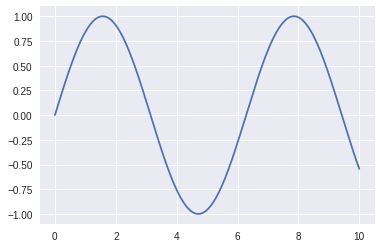

In [17]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [0]:
num_time_steps = 30

In [0]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

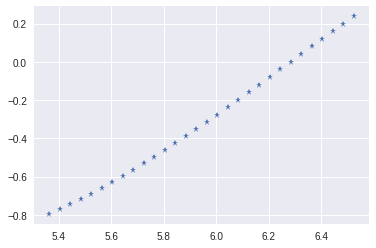

In [20]:
plt.plot(ts.flatten()[1:], y2.flatten(), '*')

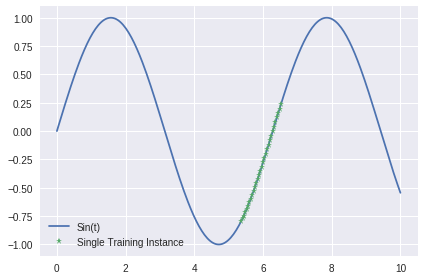

In [21]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '*', label='Single Training Instance')

plt.legend()
plt.tight_layout()

### A Training Instance and what to predict

We are trying to predict a time series shifted over by t+1

In [0]:
train_inst = np.linspace(5, 5 + ts_data.resolution * (num_time_steps+1),num_time_steps+1)

In [23]:
train_inst

array([5.        , 5.04133333, 5.08266667, 5.124     , 5.16533333,
       5.20666667, 5.248     , 5.28933333, 5.33066667, 5.372     ,
       5.41333333, 5.45466667, 5.496     , 5.53733333, 5.57866667,
       5.62      , 5.66133333, 5.70266667, 5.744     , 5.78533333,
       5.82666667, 5.868     , 5.90933333, 5.95066667, 5.992     ,
       6.03333333, 6.07466667, 6.116     , 6.15733333, 6.19866667,
       6.24      ])

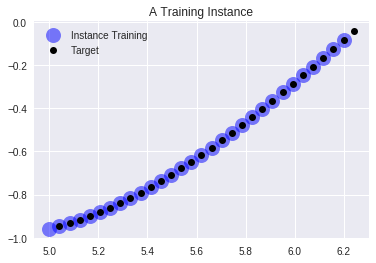

In [24]:
plt.title('A Training Instance')

plt.plot(train_inst[:-1],ts_data.ret_true(train_inst[:-1]),'bo',markersize=15,alpha=0.5,label='Instance Training')
plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]),'ko',markersize=7,label='Target')

plt.legend()

## Creating the Model

In [0]:
tf.reset_default_graph()

In [0]:
num_inputs = 1

In [0]:
num_neurons = 100

In [0]:
num_outputs = 1

In [0]:
learning_rate = 0.001

In [0]:
num_train_iteration = 2000

In [0]:
batch_size = 1

### Placeholders


In [0]:
X = tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])

In [0]:
y = tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

### RNN Cell Layer

In [0]:
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.relu),output_size=num_outputs)

In [0]:
outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [0]:
# MSE
loss = tf.reduce_mean(tf.square(outputs-y)) 

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [0]:
train = optimizer.minimize(loss)

In [0]:
init = tf.global_variables_initializer()

### Session

In [0]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)

In [0]:
saver = tf.train.Saver()

In [62]:
with tf.Session(config = tf.ConfigProto(gpu_options=gpu_options)) as sess:
  sess.run(init)
  
  for iteration in range(num_train_iteration):
    X_batch, y_batch = ts_data.next_batch(batch_size,num_time_steps)
    
    sess.run(train,feed_dict = {X:X_batch,y:y_batch})
    
    if iteration % 100 == 0:
      mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
      print(iteration, "\tMSE", mse)
      
  saver.save(sess,"./rnn_time_series_model_codealong")

0 	MSE 0.7668903
100 	MSE 0.030686842
200 	MSE 0.0052830717
300 	MSE 0.01725878
400 	MSE 0.01771579
500 	MSE 0.005394606
600 	MSE 0.0021131176
700 	MSE 0.00072153646
800 	MSE 0.0021717644
900 	MSE 0.003175331
1000 	MSE 0.00041162706
1100 	MSE 0.0019410157
1200 	MSE 0.0004917385
1300 	MSE 0.0001880892
1400 	MSE 2.3518493e-05
1500 	MSE 0.0003006468
1600 	MSE 3.8455233e-05
1700 	MSE 7.831181e-05
1800 	MSE 4.2782616e-05
1900 	MSE 0.00013099254


In [63]:
with tf.Session() as sess:
  saver.restore(sess,"./rnn_time_series_model_codealong")
  
  X_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))
  y_pred = sess.run(outputs, feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


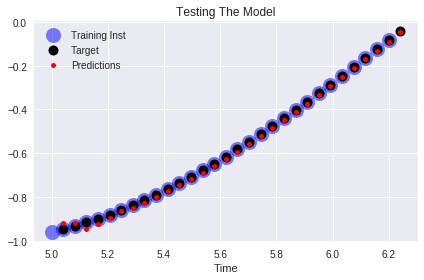

In [64]:
plt.title("Testing The Model")

# Training Instance
plt.plot(train_inst[:-1],np.sin(train_inst[:-1]),"bo",markersize=15,alpha=0.5,label="Training Inst")

# Target To Predict (Correct Test Values np.sin(Train))
plt.plot(train_inst[1:],np.sin(train_inst[1:]),"ko",markersize=10,label="Target")

# Models Prediction
plt.plot(train_inst[1:],y_pred[0,:,0],'r.',markersize=10,label="Predictions")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()

## Generating New Sequence

In [68]:
with tf.Session() as sess:
  saver.restore(sess,"./rnn_time_series_model_codealong")
  
  # Seed Zeros
  zero_seq_seed = [0.0 for i in range(num_time_steps)]
  
  for iteration in range(len(ts_data.x_data)-num_time_steps):
    X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
    
    y_pred = sess.run(outputs,feed_dict={X:X_batch})
    
    zero_seq_seed.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


Text(0, 0.5, 'Y')

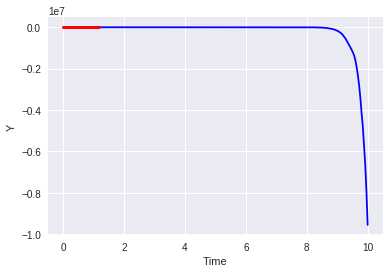

In [69]:
plt.plot(ts_data.x_data,zero_seq_seed,'b-')
plt.plot(ts_data.x_data[:num_time_steps],zero_seq_seed[:num_time_steps],'r',linewidth=3)
plt.xlabel('Time')
plt.ylabel('Y')

In [72]:
with tf.Session() as sess:
  saver.restore(sess,"./rnn_time_series_model_codealong")
  
  # Seed Zeros
  training_instance = list(ts_data.y_true[:30])
  
  for iteration in range(len(ts_data.x_data)-num_time_steps):
    X_batch = np.array(training_instance[-num_time_steps:]).reshape(1,num_time_steps,1)
    
    y_pred = sess.run(outputs,feed_dict={X:X_batch})
    
    training_instance.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


Text(0, 0.5, 'Y')

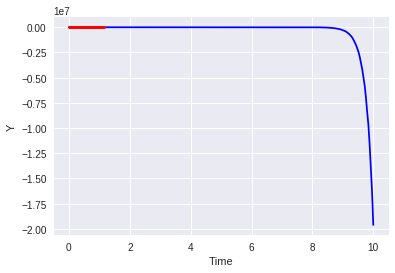

In [73]:
plt.plot(ts_data.x_data,training_instance,'b-')
plt.plot(ts_data.x_data[:num_time_steps],training_instance[:num_time_steps],'r',linewidth=3)
plt.xlabel('Time')
plt.ylabel('Y')